In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import networkx as nx


from netgraph import Graph, InteractiveGraph

from networkx.algorithms.community import girvan_newman, modularity_max, louvain_communities

from visu_utils import *

# white grid
sns.set_style("whitegrid")


%load_ext autoreload
%autoreload 2



In [2]:

PREFIX = "mteb_ds"
df_1 = pd.read_csv('exported_data/normalized_13.df')
df_2 = pd.read_csv('exported_data/normalized_multi_ds.df')

df = pd.concat([df_1, df_2])

df = text_embeddings_metadata_results_preprocessing(df, models=MODELS_MAIN_EXPES)
classifcation_df = pd.read_csv('exported_data/classification_many_3_avg.csv')

classifcation_df['model'] = classifcation_df['model'].apply(lambda x: eval(x)[0])

METRIC = "I(X_1->X_2)/d_2"


In [3]:

df

,model_1,model_2,marg_modes,cond_modes,datasets,Unnamed: 0,id,date,d_1,d_2,...,ff_residual_connection,ff_activation,ff_layer_norm,ff_layers,ff_dim_hidden,I(X_1->X_2)/H(X_2),I(X_1->X_2)/d_1,I(X_1->X_2)/d_2,X,Y
0,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5,8,8,"('ag_news/train/embeddings.npy',)",0,fff7efd4-ad49-4181-b6af-f2f0e6f7ffff,2024-04-23 23:40:23,768,768,...,False,relu,True,2,0,1.043984,1.437165,1.437165,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5
1,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5,8,8,"('dair-ai/emotion/validation/embeddings.npy',)",0,afa60d6b-641e-49d3-9033-2bee5aa3cfd8,2024-05-01 22:24:51,768,768,...,False,relu,True,2,0,0.839962,1.191112,1.191112,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5
2,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5,8,8,"('mteb/amazon_polarity/test/embeddings.npy', '...",0,90b83193-9c16-4057-a2ae-567d71679aa3,2024-04-07 14:42:10,768,768,...,False,relu,True,2,0,1.047920,1.408755,1.408755,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5
3,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5,8,8,"('mteb/amazon_polarity/test/embeddings.npy',)",0,af0a6d62-550e-48a3-88fe-7894fe196ad1,2024-04-23 23:40:54,768,768,...,False,relu,True,2,0,1.042361,1.410621,1.410621,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5
4,BAAI/bge-base-en-v1.5,GritLM/GritLM-7B,8,8,"('ag_news/train/embeddings.npy',)",0,ec6b172e-e549-4096-b8d6-53dc303af897,2024-04-24 01:14:48,768,4096,...,False,relu,True,2,0,0.466473,3.382202,0.634163,BAAI/bge-base-en-v1.5,GritLM/GritLM-7B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,thenlper/gte-large,thenlper/gte-base,8,8,"('mteb/amazon_polarity/test/embeddings.npy',)",0,86244e55-1d00-4742-8202-d6ba7f7a0575,2024-04-24 00:01:45,1024,768,...,False,relu,True,2,0,0.376907,0.388508,0.518010,thenlper/gte-large,thenlper/gte-base
7783,thenlper/gte-large,thenlper/gte-large,8,8,"('ag_news/train/embeddings.npy',)",0,35476e9c-ebce-4808-a0cf-00f2ad51cc18,2024-04-23 23:48:57,1024,1024,...,False,relu,True,2,0,1.036494,1.419277,1.419277,thenlper/gte-large,thenlper/gte-large
7784,thenlper/gte-large,thenlper/gte-large,8,8,"('dair-ai/emotion/validation/embeddings.npy',)",0,b4291c78-1098-4b18-87a4-6876c190a328,2024-05-01 22:27:19,1024,1024,...,False,relu,True,2,0,0.832358,1.180497,1.180497,thenlper/gte-large,thenlper/gte-large
7785,thenlper/gte-large,thenlper/gte-large,8,8,"('mteb/amazon_polarity/test/embeddings.npy', '...",0,c9f5895a-da48-4f24-8f10-43bef885e5f1,2024-04-07 16:06:16,1024,1024,...,False,relu,True,2,0,1.039146,1.423009,1.423009,thenlper/gte-large,thenlper/gte-large


In [4]:
correlation_table = []
for name, _df in df.groupby(['datasets']):
    
    print(name)
    
    rankings_per_task = make_rankings_table(classifcation_df, _df, METRIC, aggrefate_tasks=False)
    rankings_per_task = rankings_per_task[['model', 'dataset', 'value', 'ranking', 'rank', 'community']]


    rankings_per_task_classif = rankings_per_task[~rankings_per_task['dataset'].isna()]
    informativeness = rankings_per_task[rankings_per_task['ranking'] == 'informativeness']

    for dataset in rankings_per_task_classif['dataset'].unique():
        
        selected_ds_classif = rankings_per_task_classif[rankings_per_task_classif['dataset'] == dataset]

        temp = pd.concat([selected_ds_classif, informativeness])

        # pivot table, ranking
        temp_values = temp.pivot(columns='ranking', values='value', index=['model', 'community'])
        temp_ranking = temp.pivot(columns='ranking', values='rank', index=['model', 'community'])


        correlation_table.append({
            'Dataset' : name, 
            'Task': dataset,
            'Pearson': temp_values.corr().loc['classification', 'informativeness'],
            'Spearman': temp_ranking.corr().loc['classification', 'informativeness'],
            'Kendall-Tau': temp_values.corr(method='kendall').loc['classification', 'informativeness'],
        })

correlation_table = pd.DataFrame(correlation_table)
display(correlation_table[correlation_table['Dataset'].str.contains('bank')])
def sanitize_dataset(x):
    x = eval(x)

    if len(x) > 1:
        return "Common"
    else:
        ds = x[0]
        ds = ds.split('/')
        if len(ds) < 4:
            return ds[0]
        else:
            return "/".join(ds[:2])


correlation_table['Dataset'] = correlation_table['Dataset'].apply(sanitize_dataset)



/tmp/ipykernel_1004852/2681399704.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, _df in df.groupby(['datasets']):
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metri

('ag_news/train/embeddings.npy',)
('dair-ai/emotion/validation/embeddings.npy',)
('mteb/amazon_polarity/test/embeddings.npy', 'mteb/banking77/test/embeddings.npy', 'mteb/biosses-sts/test/embeddings.npy', 'mteb/sickr-sts/test/embeddings.npy', 'mteb/sts12-sts/test/embeddings.npy', 'mteb/sts13-sts/test/embeddings.npy', 'mteb/sts14-sts/test/embeddings.npy', 'mteb/sts15-sts/test/embeddings.npy', 'mteb/stsbenchmark-sts/test/embeddings.npy', 'mteb/stsbenchmark-sts/validation/embeddings.npy', 'snli/test/embeddings.npy', 'snli/validation/embeddings.npy')
('mteb/amazon_polarity/test/embeddings.npy',)


/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)


,Dataset,Task,Pearson,Spearman,Kendall-Tau
18,"('mteb/amazon_polarity/test/embeddings.npy', '...",ag_news,0.811706,0.780623,0.622103
19,"('mteb/amazon_polarity/test/embeddings.npy', '...",dair-ai/emotion,0.762425,0.738129,0.515152
20,"('mteb/amazon_polarity/test/embeddings.npy', '...",imdb,0.882868,0.861970,0.645503
21,"('mteb/amazon_polarity/test/embeddings.npy', '...",paws-x;en,0.275383,0.165503,0.101604
22,"('mteb/amazon_polarity/test/embeddings.npy', '...",rotten_tomatoes,0.881349,0.852755,0.657754
23,"('mteb/amazon_polarity/test/embeddings.npy', '...",tweet_eval;emoji,0.526685,0.381896,0.240642
24,"('mteb/amazon_polarity/test/embeddings.npy', '...",tweet_eval;emotion,0.708559,0.523290,0.363961
25,"('mteb/amazon_polarity/test/embeddings.npy', '...",tweet_eval;sentiment,0.845819,0.615276,0.458111
26,"('mteb/amazon_polarity/test/embeddings.npy', '...",clinc_oos;plus,0.882792,0.910283,0.722222


/tmp/ipykernel_1004852/1882459860.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[k].set_xticklabels(ax[k].get_xticklabels(), rotation=90)
/tmp/ipykernel_1004852/1882459860.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[k].set_xticklabels(ax[k].get_xticklabels(), rotation=90)
/tmp/ipykernel_1004852/1882459860.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[k].set_xticklabels(ax[k].get_xticklabels(), rotation=90)
/tmp/ipykernel_1004852/1882459860.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


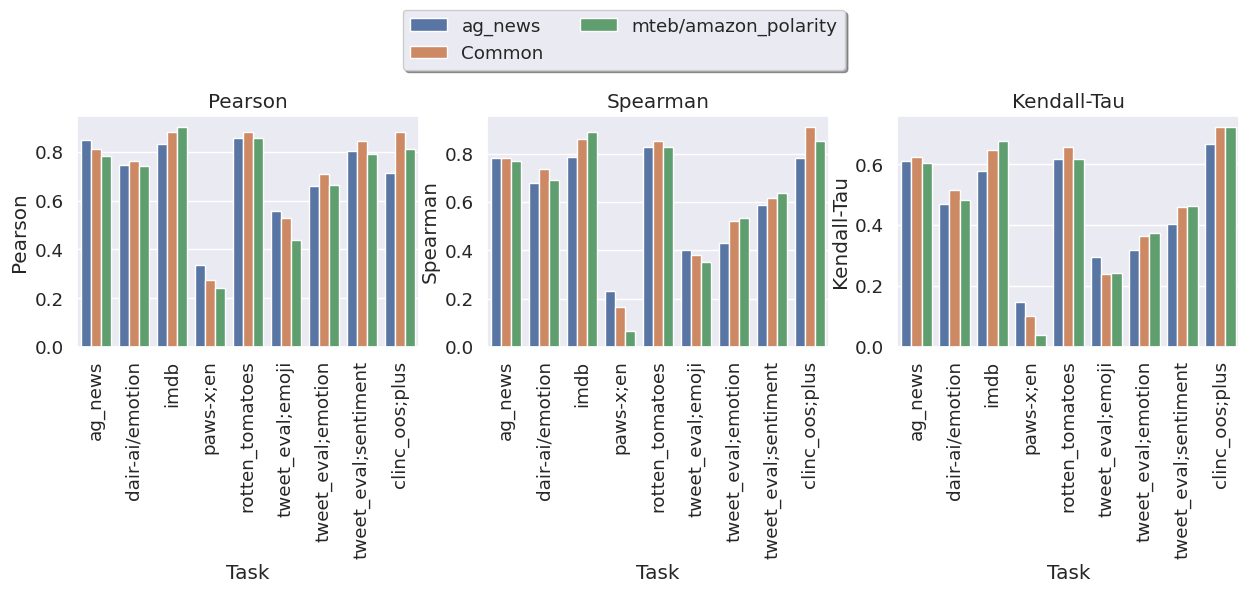

In [9]:
# remove dair from the dataset
sns.set_style("whitegrid")
sns.set(font_scale=1.2)

fig, ax= plt.subplots(1, 3, figsize=(15, 3))
correlation_table = correlation_table[~correlation_table['Dataset'].str.contains('dair')]

for k, corr in  enumerate(['Pearson', 'Spearman', 'Kendall-Tau']):
    sns.barplot(data=correlation_table, hue="Dataset", legend=True, x="Task", y=corr, ax=ax[k])
    ax[k].set_title(corr)
    ax[k].set_xticklabels(ax[k].get_xticklabels(), rotation=90)
    
    # remove legend if not last
    if k != 2:
        ax[k].get_legend().remove()
    else:
        # put the legend below the plot in the middle of the whole figure
        ax[k].legend(loc='upper center', bbox_to_anchor=(-0.8, 1.5), shadow=True, ncol=2)

sns.set_style("whitegrid")


fig.tight_layout()
path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_emir_dataset_impact_{sanitize_metric_name(METRIC)}.pdf")
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight')


In [6]:
df

,model_1,model_2,marg_modes,cond_modes,datasets,Unnamed: 0,id,date,d_1,d_2,...,ff_residual_connection,ff_activation,ff_layer_norm,ff_layers,ff_dim_hidden,I(X_1->X_2)/H(X_2),I(X_1->X_2)/d_1,I(X_1->X_2)/d_2,X,Y
0,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5,8,8,"('ag_news/train/embeddings.npy',)",0,fff7efd4-ad49-4181-b6af-f2f0e6f7ffff,2024-04-23 23:40:23,768,768,...,False,relu,True,2,0,1.043984,1.437165,1.437165,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5
1,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5,8,8,"('dair-ai/emotion/validation/embeddings.npy',)",0,afa60d6b-641e-49d3-9033-2bee5aa3cfd8,2024-05-01 22:24:51,768,768,...,False,relu,True,2,0,0.839962,1.191112,1.191112,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5
2,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5,8,8,"('mteb/amazon_polarity/test/embeddings.npy', '...",0,90b83193-9c16-4057-a2ae-567d71679aa3,2024-04-07 14:42:10,768,768,...,False,relu,True,2,0,1.047920,1.408755,1.408755,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5
3,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5,8,8,"('mteb/amazon_polarity/test/embeddings.npy',)",0,af0a6d62-550e-48a3-88fe-7894fe196ad1,2024-04-23 23:40:54,768,768,...,False,relu,True,2,0,1.042361,1.410621,1.410621,BAAI/bge-base-en-v1.5,BAAI/bge-base-en-v1.5
4,BAAI/bge-base-en-v1.5,GritLM/GritLM-7B,8,8,"('ag_news/train/embeddings.npy',)",0,ec6b172e-e549-4096-b8d6-53dc303af897,2024-04-24 01:14:48,768,4096,...,False,relu,True,2,0,0.466473,3.382202,0.634163,BAAI/bge-base-en-v1.5,GritLM/GritLM-7B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,thenlper/gte-large,thenlper/gte-base,8,8,"('mteb/amazon_polarity/test/embeddings.npy',)",0,86244e55-1d00-4742-8202-d6ba7f7a0575,2024-04-24 00:01:45,1024,768,...,False,relu,True,2,0,0.376907,0.388508,0.518010,thenlper/gte-large,thenlper/gte-base
7783,thenlper/gte-large,thenlper/gte-large,8,8,"('ag_news/train/embeddings.npy',)",0,35476e9c-ebce-4808-a0cf-00f2ad51cc18,2024-04-23 23:48:57,1024,1024,...,False,relu,True,2,0,1.036494,1.419277,1.419277,thenlper/gte-large,thenlper/gte-large
7784,thenlper/gte-large,thenlper/gte-large,8,8,"('dair-ai/emotion/validation/embeddings.npy',)",0,b4291c78-1098-4b18-87a4-6876c190a328,2024-05-01 22:27:19,1024,1024,...,False,relu,True,2,0,0.832358,1.180497,1.180497,thenlper/gte-large,thenlper/gte-large
7785,thenlper/gte-large,thenlper/gte-large,8,8,"('mteb/amazon_polarity/test/embeddings.npy', '...",0,c9f5895a-da48-4f24-8f10-43bef885e5f1,2024-04-07 16:06:16,1024,1024,...,False,relu,True,2,0,1.039146,1.423009,1.423009,thenlper/gte-large,thenlper/gte-large


/tmp/ipykernel_1004852/1043659097.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for mi_training, (name, _df) in enumerate(df.groupby(['datasets'])):
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)
/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot(

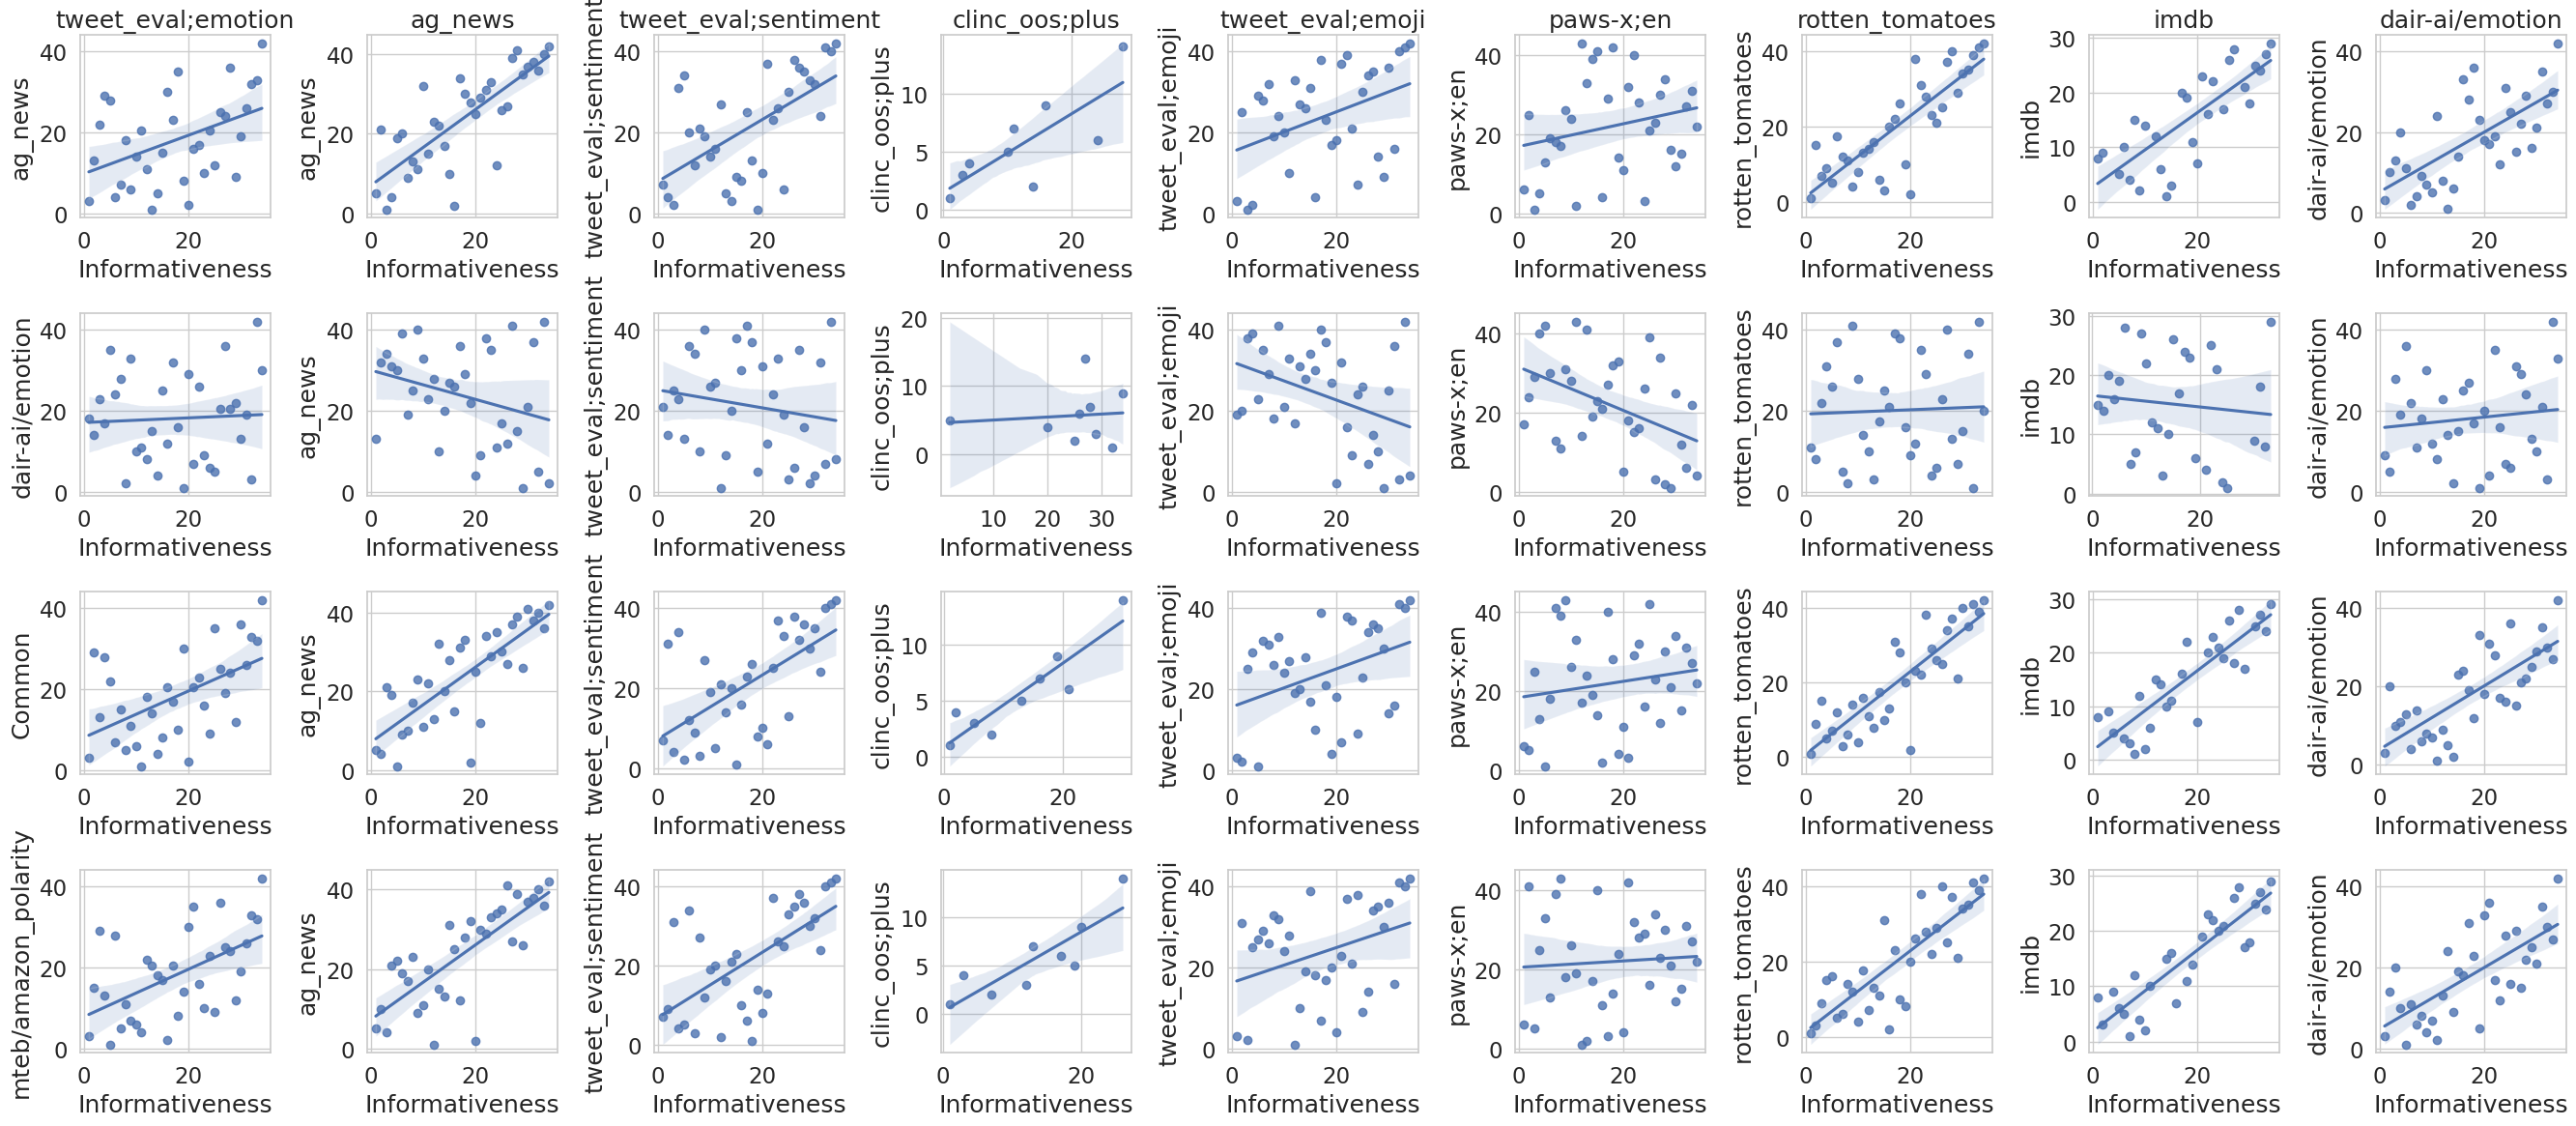

In [7]:



def nan_to_informativeness(x):
    if pd.isna(x):
        return 'informativeness'
    return x

N_mi_datasets = len(df['datasets'].unique())
N_tasks = len(classifcation_df['dataset'].unique())

fig, ax = plt.subplots(N_mi_datasets, N_tasks, figsize=(N_tasks*3, N_mi_datasets*3))

for mi_training, (name, _df) in enumerate(df.groupby(['datasets'])):
    name = eval(name)
    if len(name) > 1:
        name = "Common"
    else:
        ds = name[0]
        ds = ds.split('/')
        if len(ds) < 4:
            name=ds[0]
        else:
            name="/".join(ds[:2])
    rankings_per_task = make_rankings_table(classifcation_df, _df, METRIC, aggrefate_tasks=False)
    rankings_per_task = rankings_per_task[['model', 'dataset', 'value', 'ranking', 'rank', 'community']]
    
    
    rankings_per_task['dataset'] = rankings_per_task['dataset'].apply(nan_to_informativeness)
    
    
    tasks = set(rankings_per_task['dataset'].unique())-set(["informativeness"])
    scatter_pivot = rankings_per_task.pivot(columns='dataset', values='rank', index=['model', 'community'])
    # display(scatter_pivot)
    for i, task in enumerate(tasks):
        sns.regplot(data=scatter_pivot, x='informativeness', y=task, ax=ax[mi_training, i])
        if mi_training == 0:
            ax[mi_training, i].set_title(task)
        ax[mi_training, i].set_xlabel("Informativeness")
        if i == 0:
            ax[mi_training, i].set_ylabel(name)

fig.tight_layout()
